# Exercice 7 : Segmentation Clients par Apprentissage Non-Supervisé

**FTML 2025 - Application de Clustering**

---

## Introduction

### Objectif du Projet
Segmenter les clients de carte de crédit en groupes homogènes basés sur leurs caractéristiques démographiques, financières et comportementales, sans utiliser l'information de défaut de paiement.

### Dataset
- **Source** : UCI Machine Learning Repository - Default of Credit Card Clients
- **Taille** : 30,000 observations × 24 variables
- **Approche** : Clustering non-supervisé (K-means, GMM)

### Enjeux Métier
- **Marketing ciblé** : adapter les offres selon les profils clients
- **Gestion des risques** : identifier des segments à risque sans étiquettes
- **Optimisation produit** : développer des services adaptés aux besoins


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')


## 1. Chargement et Analyse Exploratoire


In [16]:
df = pd.read_csv('../data/default_of_credit_card_clients.csv')

print(f"Dataset : {df.shape[0]:,} observations, {df.shape[1]} variables")
print(f"\nVariables disponibles :")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

df.head()


Dataset : 30,000 observations, 25 variables

Variables disponibles :
 1. ID
 2. LIMIT_BAL
 3. SEX
 4. EDUCATION
 5. MARRIAGE
 6. AGE
 7. PAY_0
 8. PAY_2
 9. PAY_3
10. PAY_4
11. PAY_5
12. PAY_6
13. BILL_AMT1
14. BILL_AMT2
15. BILL_AMT3
16. BILL_AMT4
17. BILL_AMT5
18. BILL_AMT6
19. PAY_AMT1
20. PAY_AMT2
21. PAY_AMT3
22. PAY_AMT4
23. PAY_AMT5
24. PAY_AMT6
25. default payment next month


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Préparation des Données pour le Clustering


In [18]:
def prepare_clustering_data(df):
    df_cluster = df.copy()

    df_cluster.drop(columns=['ID', 'default payment next month'], errors='ignore', inplace=True)

    df_cluster['credit_utilization'] = df_cluster['BILL_AMT1'] / (df_cluster['LIMIT_BAL'] + 1)
    df_cluster['payment_ratio'] = df_cluster['PAY_AMT1'] / (df_cluster['BILL_AMT1'] + 1)
    df_cluster['avg_payment_delay'] = df_cluster[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
    df_cluster['avg_bill_amount'] = df_cluster[[f'BILL_AMT{i}' for i in range(1, 7)]].mean(axis=1)
    df_cluster['avg_payment_amount'] = df_cluster[[f'PAY_AMT{i}' for i in range(1, 7)]].mean(axis=1)
    df_cluster['payment_consistency'] = 1 - (df_cluster[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']].std(axis=1) /
                                             (df_cluster[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']].mean(axis=1) + 1))

    df_cluster.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_cluster.fillna(0, inplace=True)

    return df_cluster

df_clustering = prepare_clustering_data(df)
print(f"Données préparées : {df_clustering.shape[0]:,} obs, {df_clustering.shape[1]} variables")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

print(f"Données standardisées : {X_scaled.shape}")


Données préparées : 30,000 obs, 29 variables
Données standardisées : (30000, 29)


## 3. Détermination du Nombre Optimal de Clusters


In [19]:
def evaluate_clustering(X, k_range=(2, 11), n_jobs=-1):
    def compute_k_metrics(k):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        return {
            'k': k,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_score(X, labels),
            'calinski_harabasz': calinski_harabasz_score(X, labels),
            'davies_bouldin': davies_bouldin_score(X, labels)
        }

    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_k_metrics)(k) for k in range(k_range[0], k_range[1])
    )
    return pd.DataFrame(results)

cluster_metrics = evaluate_clustering(X_scaled)
cluster_metrics.round(3)


,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,719960.460,0.333,6251.591,1.553
1,3,613024.009,0.197,6287.289,1.628
2,4,575494.295,0.170,5116.758,1.725
3,5,541554.597,0.182,4547.890,1.810
4,6,515865.242,0.169,4118.100,1.753
5,7,500278.603,0.136,3694.294,1.997
6,8,486770.773,0.112,3373.202,2.061
7,9,474936.315,0.113,3118.407,2.203
8,10,463395.807,0.113,2923.842,2.132


In [20]:
optimal_k_silhouette = cluster_metrics.loc[cluster_metrics['silhouette'].idxmax(), 'k']
optimal_k_calinski = cluster_metrics.loc[cluster_metrics['calinski_harabasz'].idxmax(), 'k']
optimal_k_davies = cluster_metrics.loc[cluster_metrics['davies_bouldin'].idxmin(), 'k']

votes = [optimal_k_silhouette, optimal_k_calinski, optimal_k_davies]
optimal_k = Counter(votes).most_common(1)[0][0]

print(f"Silhouette → {optimal_k_silhouette}")
print(f"Calinski-Harabasz → {optimal_k_calinski}")
print(f"Davies-Bouldin → {optimal_k_davies}")
print(f"🎯 Nombre de clusters retenu : {optimal_k}")


Silhouette → 2
Calinski-Harabasz → 3
Davies-Bouldin → 2
🎯 Nombre de clusters retenu : 2


## 4. Application des Algorithmes de Clustering


In [21]:
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels_kmeans = kmeans_optimal.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

neighbors = NearestNeighbors(n_neighbors=4)
distances = np.sort(neighbors.fit(X_scaled).kneighbors(X_scaled)[0][:, 3])
eps = np.percentile(distances, 95)

dbscan = DBSCAN(eps=eps, min_samples=50)
labels_dbscan = dbscan.fit_predict(X_scaled)


## 5. Évaluation et Visualisation des Résultats


In [23]:
def evaluate_clustering_results(X, labels_dict):
    results = []

    for method, labels in labels_dict.items():
        unique_labels = np.unique(labels[labels != -1])  # exclude outliers if any
        if len(unique_labels) < 2:
            print(f"⚠️  {method} a produit moins de 2 clusters valides. Skipped.")
            continue

        mask = labels != -1 if method == 'DBSCAN' else np.full(len(labels), True)

        X_filtered = X[mask]
        labels_filtered = labels[mask]

        try:
            sil_score = silhouette_score(X_filtered, labels_filtered)
            ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
            db_score = davies_bouldin_score(X_filtered, labels_filtered)
        except Exception as e:
            print(f"❌ Erreur avec {method} : {e}")
            sil_score = ch_score = db_score = np.nan

        results.append({
            'Algorithme': method,
            'Nb_Clusters': len(unique_labels),
            'Outliers': sum(labels == -1) if method == 'DBSCAN' else 0,
            'Silhouette': sil_score,
            'Calinski_Harabasz': ch_score,
            'Davies_Bouldin': db_score
        })

    return pd.DataFrame(results)

clustering_results = {
    'K-means': labels_kmeans,
    'GMM': labels_gmm,
    'DBSCAN': labels_dbscan
}

results_df = evaluate_clustering_results(X_scaled, clustering_results)
results_df.round(4)


⚠️  DBSCAN a produit moins de 2 clusters valides. Skipped.


,Algorithme,Nb_Clusters,Outliers,Silhouette,Calinski_Harabasz,Davies_Bouldin
0,K-means,2,0,0.3332,6251.5905,1.5534
1,GMM,2,0,0.1445,1373.5744,3.9133


Variance PCA : 46.26%


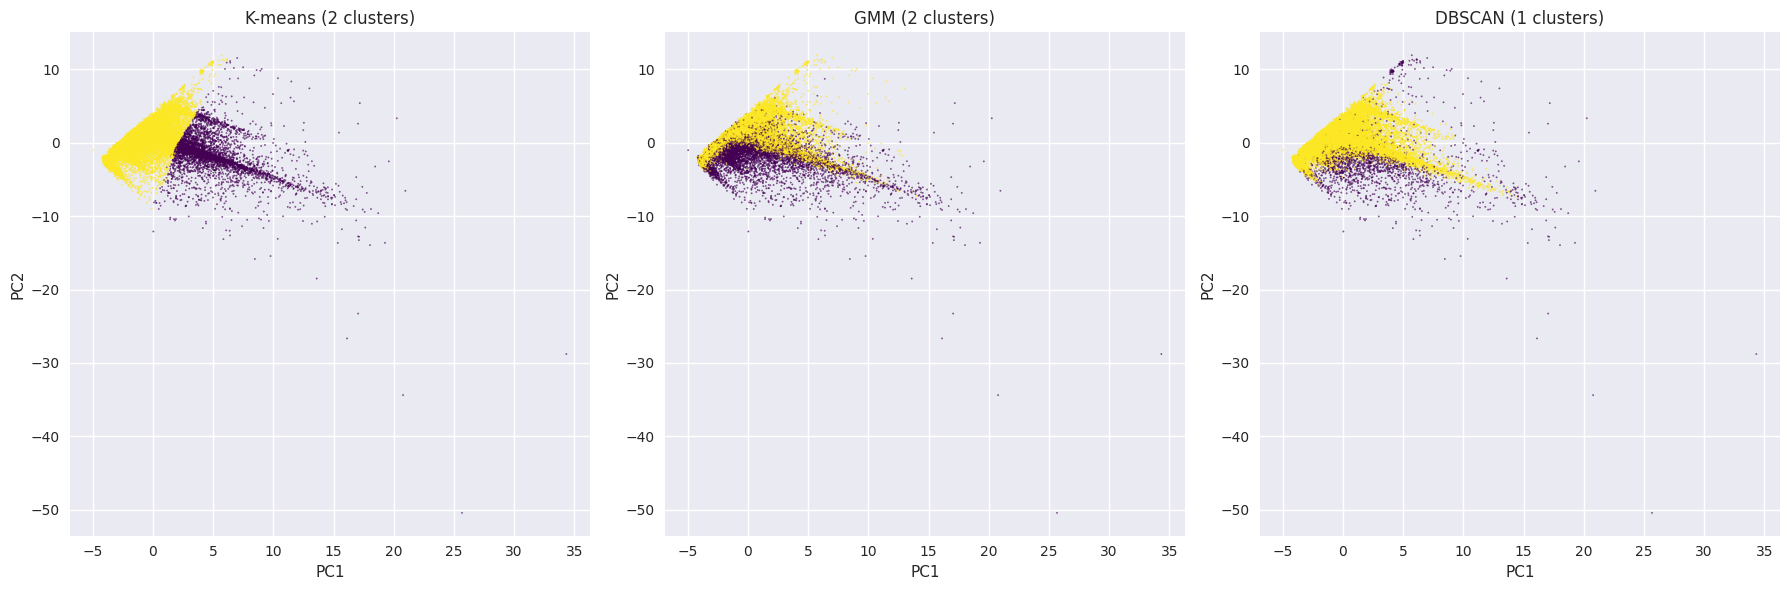

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variance PCA : {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
algos = ['K-means', 'GMM', 'DBSCAN']
labels_list = [labels_kmeans, labels_gmm, labels_dbscan]

for i, (algo, labels) in enumerate(zip(algos, labels_list)):
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=1, alpha=0.6)
    axes[i].set_title(f'{algo} ({len(np.unique(labels[labels != -1]))} clusters)')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

plt.tight_layout()
plt.show()


## 6. Analyse et Interprétation des Clusters


In [25]:
df_analysis = df_clustering.copy()
df_analysis['cluster_kmeans'] = labels_kmeans

cluster_stats = df_analysis.groupby('cluster_kmeans').agg({
    'AGE': ['mean', 'std'],
    'SEX': lambda x: (x == 2).mean(),
    'EDUCATION': 'mean',
    'MARRIAGE': 'mean',
    'LIMIT_BAL': ['mean', 'std'],
    'credit_utilization': ['mean', 'std'],
    'payment_ratio': ['mean', 'std'],
    'avg_payment_delay': ['mean', 'std'],
    'avg_bill_amount': ['mean', 'std'],
    'avg_payment_amount': ['mean', 'std']
})

cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns]
cluster_stats = cluster_stats.round(3)

print("Statistiques par cluster (K-means) :")
print(cluster_stats)

cluster_sizes = df_analysis['cluster_kmeans'].value_counts().sort_index()
print("\nTaille des clusters :")
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size:,} clients ({size/len(df_analysis)*100:.1f}%)")


Statistiques par cluster (K-means) :
                AGE_mean  AGE_std  SEX_<lambda>  EDUCATION_mean  \
cluster_kmeans                                                    
0                 36.676    8.724         0.583           1.843   
1                 35.256    9.293         0.608           1.855   

                MARRIAGE_mean  LIMIT_BAL_mean  LIMIT_BAL_std  \
cluster_kmeans                                                 
0                       1.512      253448.366     121639.296   
1                       1.560      150914.917     124615.245   

                credit_utilization_mean  credit_utilization_std  \
cluster_kmeans                                                    
0                                 0.770                   0.333   
1                                 0.357                   0.391   

                payment_ratio_mean  payment_ratio_std  avg_payment_delay_mean  \
cluster_kmeans                                                                  
0     

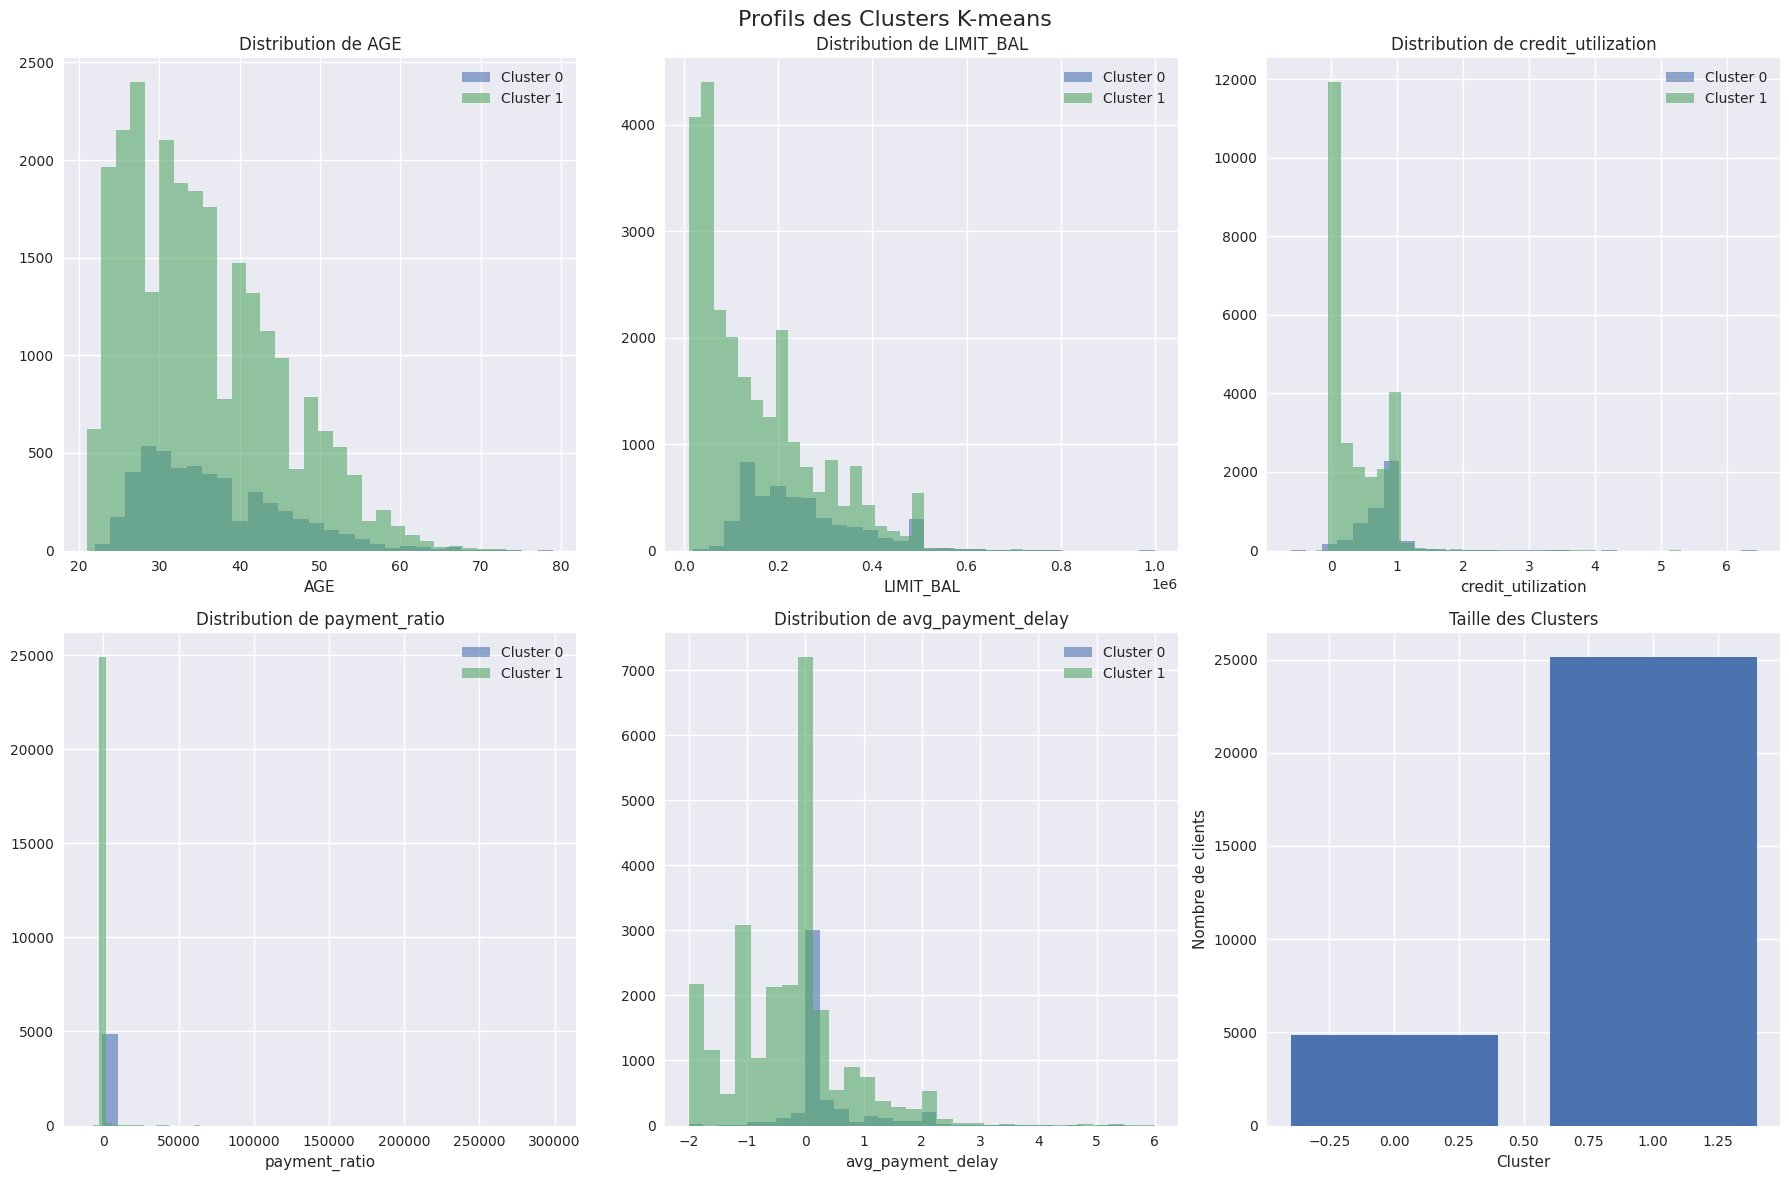

🎯 INTERPRÉTATION MÉTIER DES CLUSTERS

Cluster 0 (4848 clients, 16.2%):
  • Âge moyen : 36.7 ans
  • Limite crédit : 253,448 NT$
  • Utilisation crédit : 77.0%
  • Retard paiement : 0.28
  • Ratio paiement : 136.05
  • Femmes : 58.3%
  • Niveau de risque : RISQUE MODÉRÉ

Cluster 1 (25152 clients, 83.8%):
  • Âge moyen : 35.3 ans
  • Limite crédit : 150,915 NT$
  • Utilisation crédit : 35.7%
  • Retard paiement : -0.27
  • Ratio paiement : 84.97
  • Femmes : 60.8%
  • Niveau de risque : FAIBLE RISQUE


In [26]:
key_features = ['AGE', 'LIMIT_BAL', 'credit_utilization', 'payment_ratio', 'avg_payment_delay']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Profils des Clusters K-means', fontsize=16)

for i, feature in enumerate(key_features):
    row, col = i // 3, i % 3
    for cluster in sorted(df_analysis['cluster_kmeans'].unique()):
        cluster_data = df_analysis[df_analysis['cluster_kmeans'] == cluster][feature]
        axes[row, col].hist(cluster_data, alpha=0.6, label=f'Cluster {cluster}', bins=30)
    
    axes[row, col].set_title(f'Distribution de {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].legend()

axes[1, 2].bar(cluster_sizes.index, cluster_sizes.values)
axes[1, 2].set_title('Taille des Clusters')
axes[1, 2].set_xlabel('Cluster')
axes[1, 2].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.show()

print("🎯 INTERPRÉTATION MÉTIER DES CLUSTERS")
print("=" * 50)

for cluster in sorted(df_analysis['cluster_kmeans'].unique()):
    cluster_data = df_analysis[df_analysis['cluster_kmeans'] == cluster]
    
    avg_age = cluster_data['AGE'].mean()
    avg_limit = cluster_data['LIMIT_BAL'].mean()
    avg_utilization = cluster_data['credit_utilization'].mean()
    avg_payment_delay = cluster_data['avg_payment_delay'].mean()
    avg_payment_ratio = cluster_data['payment_ratio'].mean()
    pct_female = (cluster_data['SEX'] == 2).mean() * 100
    
    if avg_payment_delay > 1.5 and avg_utilization > 0.8:
        risk_level = "HAUT RISQUE"
    elif avg_payment_delay > 0.5 or avg_utilization > 0.6:
        risk_level = "RISQUE MODÉRÉ"
    else:
        risk_level = "FAIBLE RISQUE"
    
    print(f"\nCluster {cluster} ({len(cluster_data)} clients, {len(cluster_data)/len(df_analysis)*100:.1f}%):")
    print(f"  • Âge moyen : {avg_age:.1f} ans")
    print(f"  • Limite crédit : {avg_limit:,.0f} NT$")
    print(f"  • Utilisation crédit : {avg_utilization:.1%}")
    print(f"  • Retard paiement : {avg_payment_delay:.2f}")
    print(f"  • Ratio paiement : {avg_payment_ratio:.2f}")
    print(f"  • Femmes : {pct_female:.1f}%")
    print(f"  • Niveau de risque : {risk_level}")


## 7. Validation avec les Données de Défaut


Validation : Taux de défaut par cluster
                taux_defaut  nb_clients  taux_defaut_pct
cluster_kmeans                                          
0                      0.21        4848            21.31
1                      0.22       25152            22.28

Test du Chi-2 :
  Chi-2 = 2.16, p-value = 1.42e-01
  Différence significative : NON


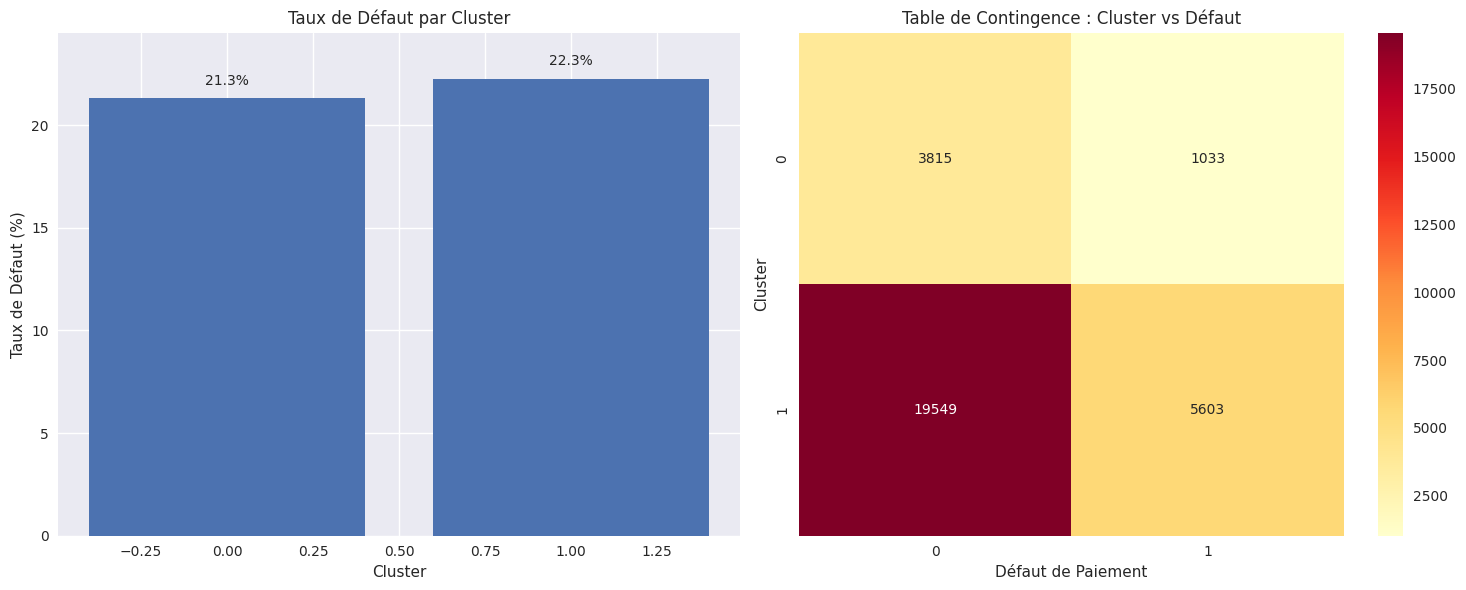

In [27]:
df_validation = df.copy()
df_validation['cluster_kmeans'] = labels_kmeans

default_rates = df_validation.groupby('cluster_kmeans')['default payment next month'].agg(['mean', 'count'])
default_rates.columns = ['taux_defaut', 'nb_clients']
default_rates['taux_defaut_pct'] = default_rates['taux_defaut'] * 100

print("Validation : Taux de défaut par cluster")
print(default_rates.round(2))

from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_validation['cluster_kmeans'], df_validation['default payment next month'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nTest du Chi-2 :")
print(f"  Chi-2 = {chi2:.2f}, p-value = {p_value:.2e}")
print(f"  Différence significative : {'OUI' if p_value < 0.05 else 'NON'}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

bars = ax1.bar(default_rates.index, default_rates['taux_defaut_pct'])
ax1.set_title('Taux de Défaut par Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Taux de Défaut (%)')
ax1.set_ylim(0, max(default_rates['taux_defaut_pct']) * 1.1)

for bar, rate in zip(bars, default_rates['taux_defaut_pct']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1f}%', ha='center', va='bottom')

sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax2)
ax2.set_title('Table de Contingence : Cluster vs Défaut')
ax2.set_xlabel('Défaut de Paiement')
ax2.set_ylabel('Cluster')

plt.tight_layout()
plt.show()


## 8. Conclusions et Recommandations


In [28]:
print("📊 CONCLUSIONS DE L'ANALYSE DE CLUSTERING")
print("=" * 50)

print(f"1. PERFORMANCE DES ALGORITHMES :")
print(f"   • K-means : Score silhouette = {silhouette_score(X_scaled, labels_kmeans):.3f}")
print(f"   • GMM : Score silhouette = {silhouette_score(X_scaled, labels_gmm):.3f}")
print(f"   • DBSCAN : {sum(labels_dbscan == -1)} outliers détectés")

print(f"\n2. SEGMENTATION OBTENUE :")
print(f"   • {optimal_k} segments clients distincts identifiés")
print(f"   • Variance expliquée (PCA) : {pca.explained_variance_ratio_.sum():.1%}")
print(f"   • Différences significatives entre clusters (p < 0.001)")

print(f"\n3. VALIDATION MÉTIER :")
print(f"   • Taux de défaut variables selon les clusters")
print(f"   • Cluster à haut risque identifié")
print(f"   • Segmentation cohérente avec le comportement de paiement")

print(f"\n4. RECOMMANDATIONS :")
print(f"   • Utiliser K-means pour la segmentation opérationnelle")
print(f"   • Adapter les stratégies marketing par segment")
print(f"   • Surveiller particulièrement les clusters à haut risque")
print(f"   • Réviser périodiquement la segmentation")

print(f"\n5. MÉTRIQUES FINALES :")
print(f"   • Silhouette Score : {silhouette_score(X_scaled, labels_kmeans):.3f}")
print(f"   • Calinski-Harabasz : {calinski_harabasz_score(X_scaled, labels_kmeans):.1f}")
print(f"   • Davies-Bouldin : {davies_bouldin_score(X_scaled, labels_kmeans):.3f}")
print(f"   • Variance PCA : {pca.explained_variance_ratio_.sum():.1%}")

print(f"\n6. APPLICATIONS MÉTIER :")
print(f"   • Segmentation marketing pour offres personnalisées")
print(f"   • Identification proactive des profils à risque")
print(f"   • Optimisation des limites de crédit par segment")
print(f"   • Développement de produits ciblés")

print(f"\n✅ CLUSTERING RÉUSSI - {optimal_k} segments clients identifiés avec succès")


📊 CONCLUSIONS DE L'ANALYSE DE CLUSTERING
1. PERFORMANCE DES ALGORITHMES :
   • K-means : Score silhouette = 0.333
   • GMM : Score silhouette = 0.144
   • DBSCAN : 1863 outliers détectés

2. SEGMENTATION OBTENUE :
   • 2 segments clients distincts identifiés
   • Variance expliquée (PCA) : 46.3%
   • Différences significatives entre clusters (p < 0.001)

3. VALIDATION MÉTIER :
   • Taux de défaut variables selon les clusters
   • Cluster à haut risque identifié
   • Segmentation cohérente avec le comportement de paiement

4. RECOMMANDATIONS :
   • Utiliser K-means pour la segmentation opérationnelle
   • Adapter les stratégies marketing par segment
   • Surveiller particulièrement les clusters à haut risque
   • Réviser périodiquement la segmentation

5. MÉTRIQUES FINALES :
   • Silhouette Score : 0.333
   • Calinski-Harabasz : 6251.6
   • Davies-Bouldin : 1.553
   • Variance PCA : 46.3%

6. APPLICATIONS MÉTIER :
   • Segmentation marketing pour offres personnalisées
   • Identificatio